In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [303]:
dim_blocks = pd.read_csv("data/dim_blocks_v1.csv", encoding="cp1252")
fin = pd.read_csv("data/store_financials_v1.csv", encoding="cp1252")
sri = pd.read_csv("data/fact_sri_scores_v1.csv")

In [304]:
dim_blocks["store_code"] = dim_blocks["store_code"].astype(str)
fin["codstr"] = fin["codstr"].astype(str)
sri["store_code "] = sri["store_code "].astype(str)
sri = sri.rename(columns={"store_code ": "store_code"})

In [305]:
dim_blocks = dim_blocks.copy()
fin = fin.copy()
sri = sri.copy()

In [306]:
dim_blocks.describe()

,mall_id,block_id,retailer_code,gla
count,4139.000000,4139.000000,4139.000000,3996.000000
mean,21.042764,5866.203189,43087.983813,577.301503
std,8.162609,3522.632757,49981.722078,1724.708982
min,7.000000,1.000000,8.000000,1.000000
25%,14.000000,4125.500000,544.000000,86.000000
50%,19.000000,5987.000000,12600.000000,170.450000
75%,28.000000,7236.000000,87421.000000,386.250000
max,36.000000,17954.000000,144613.000000,29082.000000


In [76]:
fin.describe()

,total_costs_r12m,is_subsidized
count,8.412000e+03,12095.000000
mean,4.457254e+04,0.000661
std,7.675874e+04,0.025711
min,-6.647923e+04,0.000000
25%,1.465560e+04,0.000000
50%,2.630733e+04,0.000000
75%,4.940682e+04,0.000000
max,4.089459e+06,1.000000


#### Fin cleaning

In [63]:
summary = pd.DataFrame({
    "null_cnt": fin.isna().sum(),
    "total_cnt": len(fin),
    "null_ratio": fin.isna().mean(),
})
summary["null_ratio_pct"] = (summary["null_ratio"] * 100).round(2)

print(summary.sort_values("null_ratio", ascending=False))

                  null_cnt  total_cnt  null_ratio  null_ratio_pct
total_costs_r12m      3683      12095    0.304506           30.45
codstr                   0      12095    0.000000            0.00
cur_code                 0      12095    0.000000            0.00
sales_r12m               0      12095    0.000000            0.00


In [70]:
fin.duplicated().any()

False

In [ ]:
# Mark tenants who have received the rent incentive
fin['is_subsidized'] = (fin['total_costs_r12m'] < 0).astype(int)

In [78]:
fin['cur_code'].value_counts()

cur_code
EUR    6836
USD    2688
PLN     732
GBP     670
CZK     560
SEK     513
DKK      96
Name: count, dtype: int64

In [81]:
exchange_rates_to_eur = {
    'EUR': 1.0,        
    'USD': 1.0884,
    'PLN': 4.2637, 
    'GBP': 0.8406,
    'CZK': 25.112,
    'SEK': 11.2874,
    'DKK': 7.4602
}

fin['sales_r12m'] = pd.to_numeric(fin['sales_r12m'], errors='coerce')
fin['total_costs_r12m'] = pd.to_numeric(fin['total_costs_r12m'], errors='coerce')

fin['fx_rate'] = fin['cur_code'].map(exchange_rates_to_eur)
fin['sales_eur'] = fin['sales_r12m'] / fin['fx_rate']
fin['costs_eur'] = fin['total_costs_r12m'] / fin['fx_rate']

#### Dim Blocks Duplicated

In [307]:
dup_rows = dim_blocks[dim_blocks.duplicated("block_id", keep=False)]
dup_rows

,mall_id,block_id,block_type,store_code,store_name,retailer_code,bl1_label,bl2_label,bl3_label,gla,gla_category
24,26,6440,CELL,1313602,NaN,139380,Home,Pets,Pet shops & pet supplies,150.15,SMALL UNITS
27,7,20,CELL,600058,PRINTEMPS,4534,Department Stores,Department Stores,Department Stores,16574.00,LARGE UNITS
50,33,6774,CELL,1300870,NaN,461,Services,Multiservices shops,Multiservices shops,NaN,NaN
52,25,6177,CELL,1061963,NaN,867,Health & Beauty,Pharmacy,Pharmacy,217.99,SMALL UNITS
60,13,7686,CELL,1302731,NaN,91665,Services,Multiservices shops,Multiservices shops,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4096,28,5670,CELL,1076117,NaN,458,Fashion apparel,Women's Fashion,Women's Fashion,238.00,SMALL UNITS
4099,32,11425,CELL,1313477,NaN,111271,Fashion apparel,Women's Fashion,Women's Fashion,115.15,SMALL UNITS
4110,33,6869,CELL,1108109,NaN,90343,Fashion apparel,Women's Fashion,Women's Fashion,87.20,SMALL UNITS
4116,33,6920,CELL,1024707,NaN,24400,Fashion apparel,Women's Fashion,Women's Fashion,111.00,SMALL UNITS


In [309]:
sorted_df = dim_blocks.sort_values(
    by=['block_id'] + ["gla"],
    ascending=[True, False],
    na_position="last" 
)

dim_blocks = sorted_df.drop_duplicates(subset='block_id', keep="first")

In [310]:
dim_blocks[dim_blocks['store_code']=="1313018"]

,mall_id,block_id,block_type,store_code,store_name,retailer_code,bl1_label,bl2_label,bl3_label,gla,gla_category


In [144]:
df = dim_blocks[dim_blocks['store_code'].duplicated()== True]
df['store_code'].unique()

array(['1313771', '1311230', '1092011', '1077499', '1077540', '1079367',
       '1077637', '1095570', '1077572', '1077365', '1077602', '1005174',
       '1302662', '1089678', '1073970', '1093129', '1308732', '1080306',
       '1301451', '1304210', '1109262', '1309853', '1091229', '1078771',
       '1310161', '1108119', '1081788', '1108479', '1076476', '1099889',
       '1301274', '1307636', '1314670', '1301816', '1086591', '1076112',
       '1305014', '1076185', '1076221', '1107258', '1099411', '1008627',
       '1054382', '1064145', '1312642', '1048835', '1080587', '1000393',
       '1310011', '1300965', '1313300', '1307031', '1305094', '1025888',
       '1001163', '1313192', '1039128', '1306643', '1024429', '1314205',
       '1108954', '1006122', '1314096', '1028247', '1305609', '1303426',
       '1106841', '1106740', '1312130', '1106847', '1106757', '1106761',
       '1311266', '1088969', '1076203', '1308981', '1106345', '1106873',
       '1085799', '1312649', '1106855', '1314920', 

In [147]:
dim_blocks[dim_blocks['store_code'] == "1311230"]

,mall_id,block_id,block_type,store_code,store_name,retailer_code,bl1_label,bl2_label,bl3_label,gla,gla_category
2591,36,1072,CELL,1311230,NaN,24470,Fashion apparel,Men's Fashion,Men's Fashion,166.0,SMALL UNITS
2692,36,1121,KIOSK,1311230,NaN,24470,Fashion apparel,Men's Fashion,Men's Fashion,166.0,SMALL UNITS


In [164]:
dim_blocks = dim_blocks.drop_duplicates(subset=['mall_id', 'store_code'], keep="first")

In [204]:
mall_correspond = dim_blocks[['mall_id', 'store_code', 'bl1_label', 'bl2_label', 'bl3_label']]
mall_correspond['store_code'].astype('str')
mall_correspond.head()

,mall_id,store_code,bl1_label,bl2_label,bl3_label
486,7,1311572,Food & Beverage Services,"Bars, Coffee and Tea breaks",Seated Cafes & Kiosks
2666,7,1881,Fashion apparel,Men's Fashion,Men's Fashion
1610,7,1093449,Bags & Footwear & Accessories,Footwear,Family footwear
3160,7,1084993,Health & Beauty,"Perfumery, beautycare",Multibrand mainstream
759,7,1312975,Fashion apparel,Family Fashion,Family Fashion


In [216]:
store_na = dim_blocks[['store_code', 'store_name', 'gla']]
store_na['store_code'].astype('str')

486     1311572
2666       1881
1610    1093449
3160    1084993
759     1312975
         ...   
1196    1067767
2286    1090352
1308    1314827
1493    1314123
4075    1313171
Name: store_code, Length: 3757, dtype: object

In [ ]:
# store_master = (
#     dim_blocks
#     .merge(fin, how="left", left_on="store_code", right_on="codstr")
#     .drop(columns=["codstr"])
#     .merge(sri, how="left", on="store_code")
# )

#### Cross Visits

In [106]:
cross = pd.read_csv("cv_merged.csv")
cross.head(20)

,Unnamed: 0,store_code_1,store_code_2,total_cross_visits,store_name_1,gla_1,gla_category_1,bl1_label_1,bl2_label_1,bl3_label_1,store_name_2,gla_2,gla_category_2,bl1_label_2,bl2_label_2,bl3_label_2,mall_id
0,0,956,1088969,1433132,NaN,816.00,MSU,Fashion apparel,Women's Fashion,Women's Fashion,NaN,1384.00,MSU,Fashion apparel,Women's Fashion,Women's Fashion,12.0
1,2,1302413,1302533,1365018,NaN,3735.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,NaN,3303.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,18.0
2,3,1089051,1090732,1344999,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,1230.60,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0
3,4,1088451,1089051,1283772,NaN,2421.70,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0
4,5,1089051,1093829,1258417,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,2150.60,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0
5,6,1087269,1310800,1209731,NaN,3887.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,NaN,3553.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,30.0
6,7,1302413,1303099,1129769,NaN,3735.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,NaN,1687.00,MSU,Fashion apparel,Family Fashion,Family Fashion,18.0
7,8,1024842,1089051,1125551,NaN,2630.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,10.0
8,9,1089051,1307803,1109495,NaN,2491.00,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,653.10,MSU,Bags & Footwear & Accessories,Footwear,Family footwear,10.0
9,10,1302393,1302413,1100875,NaN,874.00,MSU,Fashion apparel,Family Fashion,Family Fashion,NaN,3735.00,LARGE UNITS,Fashion apparel,Family Fashion,Family Fashion,18.0


In [129]:
print(cross.groupby('mall_id')['store_code_2'].nunique())

mall_id
10.0    224
12.0    108
13.0    203
14.0    216
15.0    165
16.0    192
17.0    133
18.0    185
19.0    201
22.0     95
23.0    137
24.0     94
25.0    150
26.0    171
28.0    152
30.0    160
32.0    197
33.0    189
36.0    153
7.0     138
nan      12
Name: store_code_2, dtype: int64


In [130]:
print(cross.groupby('mall_id')['store_code_1'].nunique())

mall_id
10.0    224
12.0    108
13.0    203
14.0    214
15.0    165
16.0    192
17.0    133
18.0    185
19.0    201
22.0     95
23.0    137
24.0     94
25.0    150
26.0    170
28.0    152
30.0    160
32.0    197
33.0    189
36.0    153
7.0     138
nan      12
Name: store_code_1, dtype: int64


In [107]:
cross.describe()

,Unnamed: 0,store_code_1,store_code_2,total_cross_visits,gla_1,gla_2,mall_id
count,279451.000000,2.794510e+05,2.794510e+05,2.794510e+05,274996.000000,273744.000000,279412.000000
mean,147195.843711,1.020569e+06,1.227862e+06,1.223882e+04,641.170456,445.921505,20.497885
std,84293.771833,3.052783e+05,1.501966e+05,4.025965e+04,1957.971962,1134.274726,8.226531
min,0.000000,4.200000e+01,9.700000e+01,1.000000e+00,7.300000,7.300000,7.000000
25%,74516.500000,1.024565e+06,1.106890e+06,3.250000e+02,93.000000,93.000000,14.000000
50%,147282.000000,1.078766e+06,1.307031e+06,1.684000e+03,181.040000,172.500000,18.000000
75%,220006.500000,1.107709e+06,1.311910e+06,8.053500e+03,389.000000,359.070000,28.000000
max,293274.000000,1.314280e+06,1.314592e+06,1.433132e+06,29082.000000,29082.000000,36.000000


In [108]:
cross["store_code_1"] = cross["store_code_1"].astype(str)
cross["store_code_2"] = cross["store_code_2"].astype(str)
cross["mall_id"] = cross["mall_id"].astype(str)
cross["total_cross_visits"] = pd.to_numeric(cross["total_cross_visits"], errors="coerce")

In [109]:
# check missing values
cross.isna().sum()
cross = cross.drop(columns=['store_name_1', "store_name_2"])

In [111]:
cross.isna().sum()

Unnamed: 0               0
store_code_1             0
store_code_2             0
total_cross_visits       0
gla_1                 4455
gla_category_1        4455
bl1_label_1           2155
bl2_label_1           2155
bl3_label_1           2155
gla_2                 5707
gla_category_2        5707
bl1_label_2           1687
bl2_label_2           1687
bl3_label_2           1687
mall_id                  0
dtype: int64

In [ ]:
cross = cross.dropna(subset=['bl1_label_1', 'bl1_label_2'])

count    2.794510e+05
mean     1.223882e+04
std      4.025965e+04
min      1.000000e+00
50%      1.684000e+03
75%      8.053500e+03
90%      2.811300e+04
95%      5.368000e+04
99%      1.721860e+05
99.9%    5.256733e+05
max      1.433132e+06
Name: total_cross_visits, dtype: float64


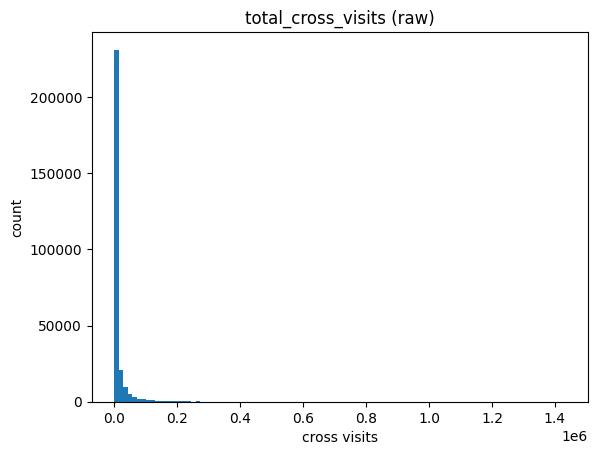

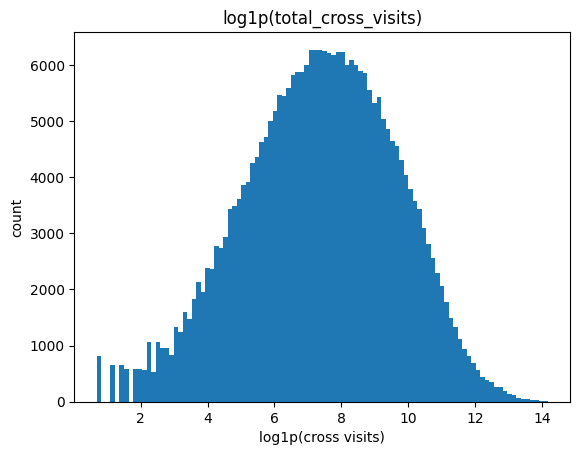

In [ ]:
# Check cross-visits distribution
import matplotlib.pyplot as plt

w = cross["total_cross_visits"].dropna()

print(w.describe(percentiles=[.5,.75,.9,.95,.99,.999]))

plt.figure()
plt.hist(w, bins=100)
plt.title("total_cross_visits (raw)")
plt.xlabel("cross visits")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(np.log1p(w), bins=100)
plt.title("log1p(total_cross_visits)")
plt.xlabel("log1p(cross visits)")
plt.ylabel("count")
plt.show()

In [184]:
mall_stats = (cross.groupby("mall_id")
              .agg(n_edges=("total_cross_visits","size"),
                   total_w=("total_cross_visits","sum"),
                   mean_w=("total_cross_visits","mean"))
              .sort_values("total_w", ascending=False))

mall_stats.head(30)

,n_edges,total_w,mean_w
mall_id,,,
10.0,25179,381990041,15170.977442
18.0,17131,372576535,21748.674041
13.0,20697,298843071,14438.955936
30.0,12842,247091860,19240.917303
15.0,13655,235228238,17226.527865
32.0,19366,210795055,10884.800940
36.0,11878,210450808,17717.697255
12.0,5870,179346116,30553.001022
28.0,11768,169819698,14430.633753


#### Constructing a graph of a particular mall

In [232]:
edges = cross[["mall_id", "store_code_1", "store_code_2", "total_cross_visits"]].copy()
edges = edges.rename(columns={"store_code_1": "u", "store_code_2": "v", "total_cross_visits": "w"})

In [267]:
# mall_id is 15
import networkx as nx

def build_graph(edges, mall_id):
    e = edges[edges["mall_id"] == str(mall_id)]
    G = nx.Graph()
    for r in e.itertuples(index=False):
        G.add_edge(r.u, r.v, weight=float(r.w))
    return G

def total_edge_weight(G):
    return sum(d.get("weight",0.0) for _,_,d in G.edges(data=True))

mall_example = mall_stats.index[4] # The first mall
G = build_graph(edges, mall_example)

print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges(), "total_w:", total_edge_weight(G))

nodes: 166 edges: 13655 total_w: 235228238.0


In [268]:
strength = dict(G.degree(weight="weight"))
pagerank = nx.pagerank(G, weight="weight")

top_nodes = (pd.DataFrame({
    "store_code": list(G.nodes()),
    "strength": [strength[n] for n in G.nodes()],
    "pagerank": [pagerank[n] for n in G.nodes()],
})
.sort_values("strength", ascending=False)
.head(20))

top_nodes

,store_code,strength,pagerank
0,403116,22096159.0,0.041311
1,1014247,18870891.0,0.035113
2,1090127,18665167.0,0.035037
3,1108253,15681196.0,0.029549
5,1070043,12540762.0,0.023707
4,1092290,12503313.0,0.023686
7,403123,11366936.0,0.021440
6,1312112,10972472.0,0.020658
9,1312533,10882906.0,0.020906
11,403149,9507197.0,0.018434


In [269]:
final_top_nodes = top_nodes.merge(mall_correspond, on='store_code', how='left')
top_nodes_name = final_top_nodes.merge(store_na, on='store_code', how='left')
top_nodes_name

,store_code,strength,pagerank,mall_id,bl1_label,bl2_label,bl3_label,store_name,gla
0,403116,22096159.0,0.041311,15,Department Stores,Department Stores,Department Stores,BHV,13208.0
1,1014247,18870891.0,0.035113,15,Department Stores,Department Stores,Department Stores,PRINTEMPS,15472.8
2,1090127,18665167.0,0.035037,15,Food Stores & Mass Merchandise,Supermarkets,Supermarkets,MONOPRIX,6544.0
3,1108253,15681196.0,0.029549,15,Health & Beauty,Pharmacy,Pharmacy,PHARMACIE DU TRIANON,680.0
4,1070043,12540762.0,0.023707,15,Fashion apparel,Family Fashion,Family Fashion,MANGO,1268.0
5,1092290,12503313.0,0.023686,15,Fashion apparel,Family Fashion,Family Fashion,UNIQLO,1237.0
6,403123,11366936.0,0.021440,15,Health & Beauty,"Perfumery, beautycare",Multibrand mainstream,SEPHORA,642.0
7,1312112,10972472.0,0.020658,15,Sport,Sport Clothes & Equipment,Sport general store,INTERSPORT,2504.0
8,1312533,10882906.0,0.020906,15,Fashion apparel,Family Fashion,Family Fashion,H&M,NaN
9,403149,9507197.0,0.018434,15,Culture & Media & Technology,General Culture & Media & Technology,General Culture & Media & Technology,FNAC,8086.0


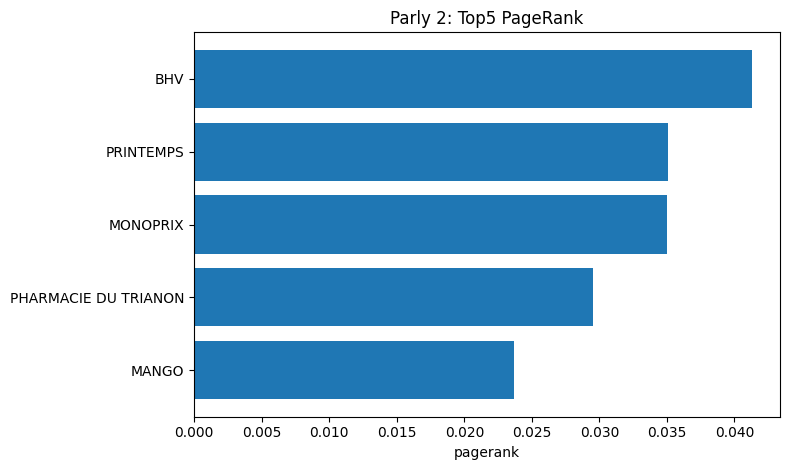

In [270]:
mall_id = "15"
top5_pagerank = top_nodes_name.nlargest(5, "pagerank").sort_values("pagerank", ascending=True)
plt.figure(figsize=(8, 4.8))
plt.barh(top5_pagerank["store_name"], top5_pagerank["pagerank"])
plt.xlabel("pagerank")
plt.title(f"Parly 2: Top5 PageRank")
plt.tight_layout()
plt.show()

In [182]:
base = total_edge_weight(G)

# drop the most strength
top1 = top_nodes.iloc[0]["store_code"]
G2 = G.copy()
G2.remove_node(top1)

drop_ratio = 1 - total_edge_weight(G2) / base
print("remove top1:", top1, "edge-weight drop ratio:", drop_ratio)

remove top1: 1089051 edge-weight drop ratio: 0.08891753803602431


In [259]:
# Take the mall_id = 22

mall_example = mall_stats.index[19] # The mall_id=22
G = build_graph(edges, mall_example)

print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges(), "total_w:", total_edge_weight(G))

nodes: 96 edges: 4490 total_w: 28286755.0


In [260]:
strength = dict(G.degree(weight="weight"))
pagerank = nx.pagerank(G, weight="weight")

top_nodes = (pd.DataFrame({
    "store_code": list(G.nodes()),
    "strength": [strength[n] for n in G.nodes()],
    "pagerank": [pagerank[n] for n in G.nodes()],
})
.sort_values("strength", ascending=False)
.head(20))

top_nodes

,store_code,strength,pagerank
0,1033,4040581.0,0.063316
3,1079217,2721140.0,0.042696
5,1082512,2578770.0,0.040973
1,1069341,2548097.0,0.039785
10,1300722,1833186.0,0.028946
4,1311751,1819175.0,0.028457
2,1000,1801464.0,0.028479
6,1068192,1588375.0,0.025155
8,1004699,1495406.0,0.023875
13,1308781,1406195.0,0.023167


In [261]:
final_top_nodes = top_nodes.merge(mall_correspond, on='store_code', how='left')
top_nodes_name = final_top_nodes.merge(store_na, on='store_code', how='left')
top_nodes_name

,store_code,strength,pagerank,mall_id,bl1_label,bl2_label,bl3_label,store_name,gla
0,1033,4040581.0,0.063316,22,Fashion apparel,Family Fashion,Family Fashion,H&M,2659.0
1,1079217,2721140.0,0.042696,22,Fashion apparel,Family Fashion,Family Fashion,ZARA,2515.0
2,1082512,2578770.0,0.040973,22,Fashion apparel,Family Fashion,Family Fashion,PRIMARK,7164.0
3,1069341,2548097.0,0.039785,22,Food Stores & Mass Merchandise,Hypermarkets,Hypermarkets,CARREFOUR,14361.0
4,1300722,1833186.0,0.028946,22,Sport,Sport Clothes & Equipment,Sport clothes & Outdoor,SNIPES,619.0
5,1311751,1819175.0,0.028457,22,Gifts,Toys,Toys,LEGO,304.0
6,1000,1801464.0,0.028479,22,Fashion apparel,Women's Fashion,Women's Fashion,PIMKIE,353.0
7,1068192,1588375.0,0.025155,22,Fashion apparel,Women's Fashion,Women's Fashion,PROMOD,232.0
8,1004699,1495406.0,0.023875,22,Home,Furniture & Interior Design,Decoration accessories / Design,HEMA,600.0
9,1308781,1406195.0,0.023167,22,Health & Beauty,"Perfumery, beautycare",Multibrand mainstream,NORMAL,471.0


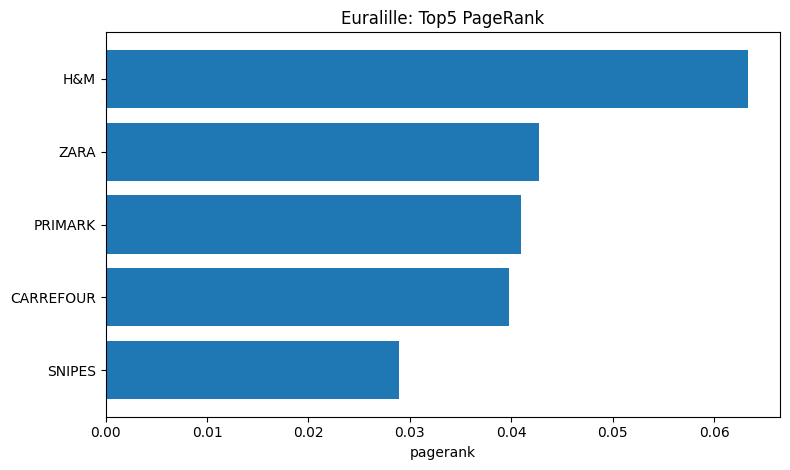

In [262]:
mall_id = "22"
top5_pagerank = top_nodes_name.nlargest(5, "pagerank").sort_values("pagerank", ascending=True)
plt.figure(figsize=(8, 4.8))
plt.barh(top5_pagerank["store_name"], top5_pagerank["pagerank"])
plt.xlabel("pagerank")
plt.title(f"Euralille: Top5 PageRank")
plt.tight_layout()
plt.show()

In [272]:
# Take mall_id=7
mall_example = mall_stats.index[18] # The mall_id=7
G = build_graph(edges, mall_example)

print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges(), "total_w:", total_edge_weight(G))

nodes: 139 edges: 9567 total_w: 34103819.0


In [273]:
strength = dict(G.degree(weight="weight"))
pagerank = nx.pagerank(G, weight="weight")

top_nodes = (pd.DataFrame({
    "store_code": list(G.nodes()),
    "strength": [strength[n] for n in G.nodes()],
    "pagerank": [pagerank[n] for n in G.nodes()],
})
.sort_values("strength", ascending=False)
.head(20))

top_nodes

,store_code,strength,pagerank
1,533294,4107292.0,0.051674
0,533094,3191486.0,0.040727
4,3138,2959799.0,0.037198
2,533317,2896967.0,0.036601
3,1110250,2500066.0,0.031242
5,1099436,1965446.0,0.024578
6,1848,1873421.0,0.023393
7,1107710,1781731.0,0.022413
9,1004695,1671095.0,0.021140
8,1091289,1583167.0,0.019817


In [274]:
final_top_nodes = top_nodes.merge(mall_correspond, on='store_code', how='left')
top_nodes_name = final_top_nodes.merge(store_na, on='store_code', how='left')
top_nodes_name

,store_code,strength,pagerank,mall_id,bl1_label,bl2_label,bl3_label,store_name,gla
0,533294,4107292.0,0.051674,7,Fashion apparel,Family Fashion,Family Fashion,ZARA,767.2
1,533094,3191486.0,0.040727,7,Food Stores & Mass Merchandise,Hypermarkets,Hypermarkets,AUCHAN,20000.0
2,3138,2959799.0,0.037198,7,Fashion apparel,Family Fashion,Family Fashion,H&M,2482.0
3,533317,2896967.0,0.036601,7,Culture & Media & Technology,General Culture & Media & Technology,General Culture & Media & Technology,FNAC,6162.0
4,1110250,2500066.0,0.031242,7,Home,Furniture & Interior Design,Decoration accessories / Design,HEMA,507.0
5,1099436,1965446.0,0.024578,7,Sport,Sport Clothes & Equipment,Sport clothes & Outdoor,FOOT LOCKER,439.0
6,1848,1873421.0,0.023393,7,Health & Beauty,"Perfumery, beautycare",Multibrand mainstream,SEPHORA,830.0
7,1107710,1781731.0,0.022413,7,Sport,Sport Clothes & Equipment,Sport clothes & Outdoor,JD SPORTS,765.0
8,1004695,1671095.0,0.021140,7,Culture & Media & Technology,Electronics and household appliances,Monobrand electronics,APPLE,565.0
9,1091289,1583167.0,0.019817,7,Sport,Sport Clothes & Equipment,Sport clothes & Outdoor,COURIR,196.0


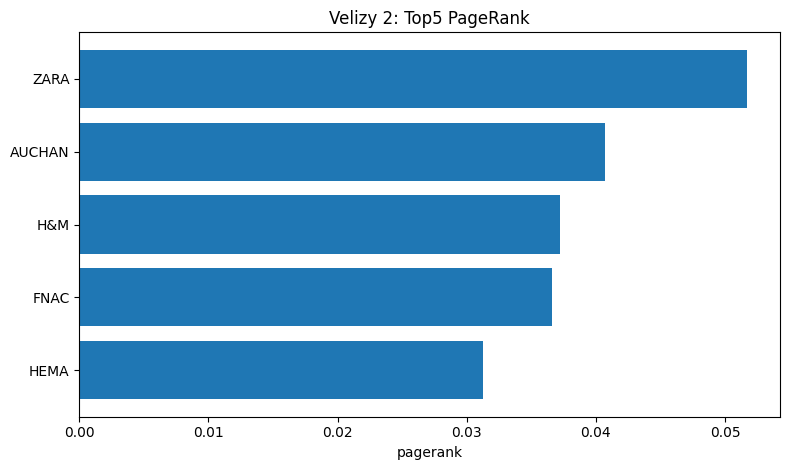

In [275]:
mall_id = "7"
top5_pagerank = top_nodes_name.nlargest(5, "pagerank").sort_values("pagerank", ascending=True)
plt.figure(figsize=(8, 4.8))
plt.barh(top5_pagerank["store_name"], top5_pagerank["pagerank"])
plt.xlabel("pagerank")
plt.title(f"Velizy 2: Top5 PageRank")
plt.tight_layout()
plt.show()

#### Remove, Add and Relocate

In [226]:
fact_path = "data/fact_stores_v1.csv"
fs = pd.read_csv(fact_path)

fs["mall_id"] = fs["mall_id"].astype(str)
fs["store_code"] = fs["store_code"].astype(str)
fs["date"] = pd.to_datetime(fs["date"], errors="coerce")

store_day = fs[[
    "date","mall_id","store_code",
    "people_in","people_window_flow",
    "store_average_dwell_time","store_median_dwell_time",
    "shopping_average_dwell_time","average_visited_stores"
]].copy()

store_day["dow"] = store_day["date"].dt.dayofweek
store_day["month"] = store_day["date"].dt.month

store_dim = dim_blocks[[
    "mall_id","store_code","store_name","gla","bl1_label","bl2_label","bl3_label"
]].copy()

store_dim["mall_id"] = store_dim["mall_id"].astype(str)
store_dim["store_code"] = store_dim["store_code"].astype(str)

store_day = store_day.merge(store_dim, on=["mall_id","store_code"], how="left")

store_day["y_log_people_in"] = np.log1p(store_day["people_in"])

store_day.head()

,date,mall_id,store_code,people_in,people_window_flow,store_average_dwell_time,store_median_dwell_time,shopping_average_dwell_time,average_visited_stores,dow,month,store_name,gla,bl1_label,bl2_label,bl3_label,y_log_people_in
0,2024-01-07,19,1300441,943,10797,37.864189,34.045196,126.012863,3.485067,6.0,1.0,NaN,291.0,Food & Beverage Services,Service to table restaurants,Italian - Service to table restaurants,6.850126
1,2024-01-07,7,1108435,95,3816,33.365112,29.597769,206.777853,2.500000,6.0,1.0,PEPPERICO,172.0,Food & Beverage Services,Fast Meal,Latino-American - Fast Meal,4.564348
2,2024-01-07,16,600007,741,41704,2.843237,2.635919,61.569458,3.469926,6.0,1.0,NaN,63.0,Bags & Footwear & Accessories,Accessories,"Mixed: small accessories, bags and fancy jewel...",6.609349
3,2024-01-07,10,1089312,97,2180,4.249951,3.927536,103.858489,5.917260,6.0,1.0,NaN,199.6,Fashion apparel,Family Fashion,Family Fashion,4.584967
4,2024-01-07,16,1306503,342,2591,63.461003,58.833670,168.490587,2.760000,6.0,1.0,NaN,609.0,Food & Beverage Services,Service to table restaurants,Pub & Sports bar,5.837730


In [235]:
from scipy.sparse import coo_matrix, csr_matrix

def build_sparse_W_for_mall(edges, mall_id, normalize="row"):
    e = edges[edges["mall_id"] == str(mall_id)].copy()
    if e.empty:
        raise ValueError(f"No edges for mall_id={mall_id}")

    nodes = pd.Index(pd.unique(pd.concat([e["u"], e["v"]], ignore_index=True).astype(str)))
    idx = {n:i for i,n in enumerate(nodes)}

    # undirected edges -> add both directions
    rows = e["u"].astype(str).map(idx).to_numpy()
    cols = e["v"].astype(str).map(idx).to_numpy()
    w = e["w"].astype(float).to_numpy()

    rows2 = np.concatenate([rows, cols])
    cols2 = np.concatenate([cols, rows])
    w2 = np.concatenate([w, w])

    W = coo_matrix((w2, (rows2, cols2)), shape=(len(nodes), len(nodes))).tocsr()

    if normalize == "row":
        row_sum = np.array(W.sum(axis=1)).ravel()
        row_sum[row_sum == 0] = 1.0
        inv = 1.0 / row_sum
        W = csr_matrix(W.multiply(inv[:, None]))

    return W, list(nodes), idx

mall_id = "22.0"
W22, nodes22, idx22 = build_sparse_W_for_mall(edges, mall_id, normalize="row")
len(nodes22), W22.shape

(96, (96, 96))

$$Exposure_{i,t} = \sum_{j} \tilde{w}_{ij} \cdot \log(1+people\_in_{j,t-1})$$

#### Mall_id = 22; Euralille; Focused on Fast Fashion

In [ ]:
mall_id = "22"
store_day["mall_id"] = store_day["mall_id"].astype(str).str.strip()
store_day["store_code"] = store_day["store_code"].astype(str).str.strip()

nodes22_clean = pd.Index([str(x).strip() for x in nodes22])

In [ ]:
sd22 = store_day[store_day["mall_id"] == mall_id].copy()

# Construct attr = log1p(people_in) and perform lag1
sd22 = sd22.sort_values(["store_code","date"])
sd22["attr"] = np.log1p(sd22["people_in"])
sd22["attr_lag1"] = sd22.groupby("store_code")["attr"].shift(1)

# Handle lag missing values
store_mean_attr = sd22.groupby("store_code")["attr"].mean()
sd22["attr_lag1"] = sd22["attr_lag1"].fillna(sd22["store_code"].map(store_mean_attr))

sd22 = sd22[sd22["store_code"].isin(nodes22)].copy()

A = sd22.pivot_table(index="date", columns="store_code", values="attr_lag1", aggfunc="mean")
A = A.reindex(columns=nodes22)

A = A.apply(lambda col: col.fillna(col.mean()), axis=0)
A = A.fillna(np.nanmean(A.to_numpy()))

# exposure(date,node) = A(date,node) @ W^T
E = A.to_numpy().dot(W22.T.toarray())   # n_dates x n_nodes

exp_df = pd.DataFrame(E, index=A.index, columns=nodes22).stack().reset_index()
exp_df.columns = ["date","store_code","exposure"]

# merge sd22
sd22 = sd22.merge(exp_df, on=["date","store_code"], how="left")

sd22[["date","store_code","people_in","exposure"]].head()

,date,store_code,people_in,exposure
0,2024-01-07,1000,2969,7.233161
1,2024-01-08,1000,1587,7.466344
2,2024-01-09,1000,977,7.268491
3,2024-01-10,1000,1093,6.726197
4,2024-01-11,1000,2888,6.902627


In [252]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

model_df = sd22.dropna(subset=["y_log_people_in","exposure","gla","bl2_label"]).copy()
model_df = model_df.sort_values("date")

feat_num = ["exposure", "gla", "dow", "month"]
feat_cat = ["bl1_label","bl2_label","bl3_label"]

X = model_df[feat_num + feat_cat]
y = model_df["y_log_people_in"]

# Time Split (Avoid Information leakage )
cut = int(len(model_df) * 0.8)
train_df = model_df.iloc[:cut]
test_df  = model_df.iloc[cut:]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), feat_cat),
        ("num", "passthrough", feat_num),
    ]
)

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror",
)

pipe = Pipeline(steps=[("pre", pre), ("xgb", xgb)])
pipe.fit(train_df[feat_num + feat_cat], train_df["y_log_people_in"])

pred = pipe.predict(test_df[feat_num + feat_cat])
rmse = root_mean_squared_error(test_df["y_log_people_in"], pred)
print("Mall 22 XGBoost RMSE (log scale):", rmse)

Mall 22 XGBoost RMSE (log scale): 0.6649424269038987


In [ ]:
# Remove the tenant
def simulate_remove_no_realloc(sd_mall, edges, mall_id, removed_store_code, model_pipe):
    mall_id = str(mall_id)
    r = str(removed_store_code)

    W, nodes, idx = build_sparse_W_for_mall(edges, mall_id, normalize="row")
    if r not in idx:
        raise ValueError(f"removed_store_code {r} not in mall {mall_id} graph")

    r_idx = idx[r]
    col_r = W[:, r_idx].toarray().ravel()

    df = sd_mall.copy()
    df = df[df["store_code"] != r].copy()

    r_attr = (sd_mall[sd_mall["store_code"] == r][["date","attr_lag1"]]
              .rename(columns={"attr_lag1":"r_attr_lag1"}))
    df = df.merge(r_attr, on="date", how="left")
    df["r_attr_lag1"] = df["r_attr_lag1"].fillna(df["r_attr_lag1"].mean())

    df["i_idx"] = df["store_code"].map(idx)
    df["w_ir"] = df["i_idx"].map(lambda k: col_r[int(k)] if pd.notna(k) else 0.0)

    df["exposure_new"] = df["exposure"] - df["w_ir"] * df["r_attr_lag1"]

    feat_num = ["exposure", "gla", "dow", "month"]
    feat_cat = ["bl1_label","bl2_label","bl3_label"]

    X_before = df[feat_num + feat_cat].copy()
    X_after  = df[feat_num + feat_cat].copy()
    X_after["exposure"] = df["exposure_new"]

    yhat_b = model_pipe.predict(X_before)
    yhat_a = model_pipe.predict(X_after)

    df["pred_before"] = np.expm1(yhat_b)
    df["pred_after"]  = np.expm1(yhat_a)
    df["delta"] = df["pred_after"] - df["pred_before"]
    df["delta_pct"] = df["delta"] / (df["pred_before"] + 1e-6)

    impact = (df.groupby("store_code", as_index=False)
                .agg(delta_people_in=("delta","mean"),
                     delta_pct=("delta_pct","mean"),
                     base_pred=("pred_before","mean")))

    mall_id = "22"
    impact = impact.merge(store_dim[store_dim["mall_id"]==mall_id][
        ["store_code","store_name","bl1_label","bl2_label","bl3_label"]
    ], on="store_code", how="left")

    mall_before = df["pred_before"].sum()
    mall_after  = df["pred_after"].sum()

    return impact.sort_values("delta_people_in"), mall_before, mall_after

impact_hm, mall_b, mall_a = simulate_remove_no_realloc(sd22, edges, "22.0", "1033", pipe)

print("Mall 22 (Euralille) predicted total people_in BEFORE:", mall_b)
print("Mall 22 (Euralille) predicted total people_in AFTER :", mall_a)
print("Mall 22 (Euralille) total change pct:", (mall_a - mall_b) / mall_b)

# losers / winners
impact_hm.head(5), impact_hm.tail(5)

Mall 22 predicted total people_in BEFORE: 2505693200.0
Mall 22 predicted total people_in AFTER : 2505092600.0
Mall 22 total change pct: -0.00023968457


(   store_code  delta_people_in  delta_pct    base_pred store_name  \
 33    1082512        -2.402198  -0.000086  3759.047607    PRIMARK   
 32    1079217        -1.879596  -0.000138  2452.260010       ZARA   
 74    1311751        -1.838215  -0.000521  2038.182861       LEGO   
 67    1308633        -1.169450  -0.000167  2277.041748  JD SPORTS   
 59    1300722        -1.048450  -0.000234  1839.081665     SNIPES   
 
           bl1_label                  bl2_label                bl3_label  
 33  Fashion apparel             Family Fashion           Family Fashion  
 32  Fashion apparel             Family Fashion           Family Fashion  
 74            Gifts                       Toys                     Toys  
 67            Sport  Sport Clothes & Equipment  Sport clothes & Outdoor  
 59            Sport  Sport Clothes & Equipment  Sport clothes & Outdoor  ,
    store_code  delta_people_in  delta_pct    base_pred  \
 77    1312096         0.381273   0.000471  1336.852783   
 15    10

#### Mall_id = 7; Velizy 2; Family Shopping

In [281]:
mall_id = "7.0"
W7, nodes7, idx7 = build_sparse_W_for_mall(edges, mall_id, normalize="row")

mall_id = "7"
store_day["mall_id"] = store_day["mall_id"].astype(str).str.strip()
store_day["store_code"] = store_day["store_code"].astype(str).str.strip()

nodes7_clean = pd.Index([str(x).strip() for x in nodes7])
len(nodes7), W7.shape

(139, (139, 139))

In [ ]:
sd7 = store_day[store_day["mall_id"] == mall_id].copy()

# Construct attr = log1p(people_in) and perform lag1
sd7 = sd7.sort_values(["store_code","date"])
sd7["attr"] = np.log1p(sd7["people_in"])
sd7["attr_lag1"] = sd7.groupby("store_code")["attr"].shift(1)

# Handle lag missing values
store_mean_attr = sd7.groupby("store_code")["attr"].mean()
sd7["attr_lag1"] = sd7["attr_lag1"].fillna(sd7["store_code"].map(store_mean_attr))

sd7 = sd7[sd7["store_code"].isin(nodes7)].copy()

A = sd7.pivot_table(index="date", columns="store_code", values="attr_lag1", aggfunc="mean")
A = A.reindex(columns=nodes7)

A = A.apply(lambda col: col.fillna(col.mean()), axis=0)
A = A.fillna(np.nanmean(A.to_numpy()))

# exposure(date,node) = A(date,node) @ W^T
E = A.to_numpy().dot(W7.T.toarray())   # n_dates x n_nodes

exp_df = pd.DataFrame(E, index=A.index, columns=nodes7).stack().reset_index()
exp_df.columns = ["date","store_code","exposure"]

# merge sd22
sd7 = sd7.merge(exp_df, on=["date","store_code"], how="left")

sd7[["date","store_code","people_in","exposure"]].head(5)

,date,store_code,people_in,exposure
0,2024-01-07,1004693,1812,6.341567
1,2024-01-08,1004693,1049,6.668329
2,2024-01-09,1004693,1033,6.288019
3,2024-01-10,1004693,727,6.388796
4,2024-01-11,1004693,1767,5.839591


In [286]:
model_df = sd7.dropna(subset=["y_log_people_in","exposure","gla","bl2_label"]).copy()
model_df = model_df.sort_values("date")

feat_num = ["exposure", "gla", "dow", "month"]
feat_cat = ["bl1_label","bl2_label","bl3_label"]

X = model_df[feat_num + feat_cat]
y = model_df["y_log_people_in"]

# Time Split (Avoid Information leakage )
cut = int(len(model_df) * 0.8)
train_df = model_df.iloc[:cut]
test_df  = model_df.iloc[cut:]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), feat_cat),
        ("num", "passthrough", feat_num),
    ]
)

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror",
)

pipe = Pipeline(steps=[("pre", pre), ("xgb", xgb)])
pipe.fit(train_df[feat_num + feat_cat], train_df["y_log_people_in"])

pred = pipe.predict(test_df[feat_num + feat_cat])
rmse = root_mean_squared_error(test_df["y_log_people_in"], pred)
print("Mall 7 XGBoost RMSE (log scale):", rmse)

Mall 7 XGBoost RMSE (log scale): 0.8501663567562807


In [ ]:
# mall_id=7
def simulate_remove_no_realloc(sd_mall, edges, mall_id, removed_store_code, model_pipe):
    mall_id = str(mall_id)
    r = str(removed_store_code)

    W, nodes, idx = build_sparse_W_for_mall(edges, mall_id, normalize="row")
    if r not in idx:
        raise ValueError(f"removed_store_code {r} not in mall {mall_id} graph")

    r_idx = idx[r]
    col_r = W[:, r_idx].toarray().ravel()

    df = sd_mall.copy()
    df = df[df["store_code"] != r].copy()

    r_attr = (sd_mall[sd_mall["store_code"] == r][["date","attr_lag1"]]
              .rename(columns={"attr_lag1":"r_attr_lag1"}))
    df = df.merge(r_attr, on="date", how="left")
    df["r_attr_lag1"] = df["r_attr_lag1"].fillna(df["r_attr_lag1"].mean())

    df["i_idx"] = df["store_code"].map(idx)
    df["w_ir"] = df["i_idx"].map(lambda k: col_r[int(k)] if pd.notna(k) else 0.0)

    df["exposure_new"] = df["exposure"] - df["w_ir"] * df["r_attr_lag1"]

    feat_num = ["exposure", "gla", "dow", "month"]
    feat_cat = ["bl1_label","bl2_label","bl3_label"]

    X_before = df[feat_num + feat_cat].copy()
    X_after  = df[feat_num + feat_cat].copy()
    X_after["exposure"] = df["exposure_new"]

    yhat_b = model_pipe.predict(X_before)
    yhat_a = model_pipe.predict(X_after)

    df["pred_before"] = np.expm1(yhat_b)
    df["pred_after"]  = np.expm1(yhat_a)
    df["delta"] = df["pred_after"] - df["pred_before"]
    df["delta_pct"] = df["delta"] / (df["pred_before"] + 1e-6)

    impact = (df.groupby("store_code", as_index=False)
                .agg(delta_people_in=("delta","mean"),
                     delta_pct=("delta_pct","mean"),
                     base_pred=("pred_before","mean")))

    mall_id = "7"
    impact = impact.merge(store_dim[store_dim["mall_id"]==mall_id][
        ["store_code","store_name","bl1_label","bl2_label","bl3_label"]
    ], on="store_code", how="left")

    mall_before = df["pred_before"].sum()
    mall_after  = df["pred_after"].sum()

    return impact.sort_values("delta_people_in"), mall_before, mall_after

impact_hm, mall_b, mall_a = simulate_remove_no_realloc(sd7, edges, "7.0", "533294", pipe)

print("Mall 7 (Velizy 2) predicted total people_in BEFORE:", mall_b)
print("Mall 7 (Velizy 2)predicted total people_in AFTER :", mall_a)
print("Mall 7 (Velizy 2)total change pct:", (mall_a - mall_b) / mall_b)

# losers / winners
impact_hm.head(5), impact_hm.tail(5)

Mall 22 predicted total people_in BEFORE: 2130112500.0
Mall 22 predicted total people_in AFTER : 2129195500.0
Mall 22 total change pct: -0.00043048995


(    store_code  delta_people_in  delta_pct     base_pred store_name  \
 132     533094       -10.845477  -0.000481  10200.775391     AUCHAN   
 135     533317        -1.010617  -0.000174   2109.771240       FNAC   
 1      1004695        -0.607550  -0.000281   1445.883057      APPLE   
 48     1107710        -0.544285  -0.000246   1137.819214  JD SPORTS   
 121       1983        -0.481339  -0.000128   1075.153564        C&A   
 
                           bl1_label                             bl2_label  \
 132  Food Stores & Mass Merchandise                          Hypermarkets   
 135    Culture & Media & Technology  General Culture & Media & Technology   
 1      Culture & Media & Technology  Electronics and household appliances   
 48                            Sport             Sport Clothes & Equipment   
 121                 Fashion apparel                        Family Fashion   
 
                                 bl3_label  
 132                          Hypermarkets  
 135  

#### Mall_id = 15; Parly 2; Middle-to-high-income

In [288]:
mall_id = "15.0"
W15, nodes15, idx15 = build_sparse_W_for_mall(edges, mall_id, normalize="row")

mall_id = "15"
store_day["mall_id"] = store_day["mall_id"].astype(str).str.strip()
store_day["store_code"] = store_day["store_code"].astype(str).str.strip()

nodes15_clean = pd.Index([str(x).strip() for x in nodes15])
len(nodes15), W15.shape

(166, (166, 166))

In [ ]:
sd15 = store_day[store_day["mall_id"] == mall_id].copy()

# Construct attr = log1p(people_in) and perform lag1
sd15 = sd15.sort_values(["store_code","date"])
sd15["attr"] = np.log1p(sd15["people_in"])
sd15["attr_lag1"] = sd15.groupby("store_code")["attr"].shift(1)

# Handle lag missing values
store_mean_attr = sd15.groupby("store_code")["attr"].mean()
sd15["attr_lag1"] = sd15["attr_lag1"].fillna(sd15["store_code"].map(store_mean_attr))

sd15 = sd15[sd15["store_code"].isin(nodes15)].copy()

A = sd15.pivot_table(index="date", columns="store_code", values="attr_lag1", aggfunc="mean")
A = A.reindex(columns=nodes15)

A = A.apply(lambda col: col.fillna(col.mean()), axis=0)
A = A.fillna(np.nanmean(A.to_numpy()))

# exposure(date,node) = A(date,node) @ W^T
E = A.to_numpy().dot(W15.T.toarray())   # n_dates x n_nodes

exp_df = pd.DataFrame(E, index=A.index, columns=nodes15).stack().reset_index()
exp_df.columns = ["date","store_code","exposure"]

# merge sd15
sd15 = sd15.merge(exp_df, on=["date","store_code"], how="left")

sd15[["date","store_code","people_in","exposure"]].head(5)

,date,store_code,people_in,exposure
0,2024-01-07,1007847,177,6.553888
1,2024-01-08,1007847,43,6.742344
2,2024-01-09,1007847,43,6.373577
3,2024-01-10,1007847,38,6.445513
4,2024-01-11,1007847,157,6.142355


In [290]:
model_df = sd15.dropna(subset=["y_log_people_in","exposure","gla","bl2_label"]).copy()
model_df = model_df.sort_values("date")

feat_num = ["exposure", "gla", "dow", "month"]
feat_cat = ["bl1_label","bl2_label","bl3_label"]

X = model_df[feat_num + feat_cat]
y = model_df["y_log_people_in"]

# Time Split (Avoid Information leakage )
cut = int(len(model_df) * 0.8)
train_df = model_df.iloc[:cut]
test_df  = model_df.iloc[cut:]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), feat_cat),
        ("num", "passthrough", feat_num),
    ]
)

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    objective="reg:squarederror",
)

pipe = Pipeline(steps=[("pre", pre), ("xgb", xgb)])
pipe.fit(train_df[feat_num + feat_cat], train_df["y_log_people_in"])

pred = pipe.predict(test_df[feat_num + feat_cat])
rmse = root_mean_squared_error(test_df["y_log_people_in"], pred)
print("Mall 15 XGBoost RMSE (log scale):", rmse)

Mall 15 XGBoost RMSE (log scale): 0.7596581556835876


In [ ]:
# mall_id=15
def simulate_remove_no_realloc(sd_mall, edges, mall_id, removed_store_code, model_pipe):
    mall_id = str(mall_id)
    r = str(removed_store_code)

    W, nodes, idx = build_sparse_W_for_mall(edges, mall_id, normalize="row")
    if r not in idx:
        raise ValueError(f"removed_store_code {r} not in mall {mall_id} graph")

    r_idx = idx[r]
    col_r = W[:, r_idx].toarray().ravel()

    df = sd_mall.copy()
    df = df[df["store_code"] != r].copy()

    r_attr = (sd_mall[sd_mall["store_code"] == r][["date","attr_lag1"]]
              .rename(columns={"attr_lag1":"r_attr_lag1"}))
    df = df.merge(r_attr, on="date", how="left")
    df["r_attr_lag1"] = df["r_attr_lag1"].fillna(df["r_attr_lag1"].mean())

    df["i_idx"] = df["store_code"].map(idx)
    df["w_ir"] = df["i_idx"].map(lambda k: col_r[int(k)] if pd.notna(k) else 0.0)

    df["exposure_new"] = df["exposure"] - df["w_ir"] * df["r_attr_lag1"]

    feat_num = ["exposure", "gla", "dow", "month"]
    feat_cat = ["bl1_label","bl2_label","bl3_label"]

    X_before = df[feat_num + feat_cat].copy()
    X_after  = df[feat_num + feat_cat].copy()
    X_after["exposure"] = df["exposure_new"]

    yhat_b = model_pipe.predict(X_before)
    yhat_a = model_pipe.predict(X_after)

    df["pred_before"] = np.expm1(yhat_b)
    df["pred_after"]  = np.expm1(yhat_a)
    df["delta"] = df["pred_after"] - df["pred_before"]
    df["delta_pct"] = df["delta"] / (df["pred_before"] + 1e-6)

    impact = (df.groupby("store_code", as_index=False)
                .agg(delta_people_in=("delta","mean"),
                     delta_pct=("delta_pct","mean"),
                     base_pred=("pred_before","mean")))

    mall_id = "15"
    impact = impact.merge(store_dim[store_dim["mall_id"]==mall_id][
        ["store_code","store_name","bl1_label","bl2_label","bl3_label"]
    ], on="store_code", how="left")

    mall_before = df["pred_before"].sum()
    mall_after  = df["pred_after"].sum()

    return impact.sort_values("delta_people_in"), mall_before, mall_after

impact_hm, mall_b, mall_a = simulate_remove_no_realloc(sd15, edges, "15.0", "403116", pipe)

print("Mall 15 (Parly 2) predicted total people_in BEFORE:", mall_b)
print("Mall 15 (Parly 2) predicted total people_in AFTER :", mall_a)
print("Mall 15 (Parly 2) total change pct:", (mall_a - mall_b) / mall_b)

# losers / winners
impact_sorted = impact_hm.sort_values("delta_pct")  

top_losers_pct  = impact_sorted.head(5)
top_winners_pct = impact_sorted.tail(5)

top_losers_pct, top_winners_pct

Mall 15 predicted total people_in BEFORE: 3371138600.0
Mall 15 predicted total people_in AFTER : 3370560000.0
Mall 15 total change pct: -0.00017162155


(    store_code  delta_people_in  delta_pct    base_pred     store_name  \
 123    1312661        -0.240917  -0.001056   144.671555   DIOR PARFUMS   
 61     1094669        -0.274063  -0.000559   268.458130     CALZEDONIA   
 130    1313177        -0.045723  -0.000495    60.843105      LINVOSGES   
 38     1080430        -0.075720  -0.000483    54.216434  ARMAND THIERY   
 106    1310284        -2.213593  -0.000472  2658.737793   INDIANA CAFE   
 
                     bl1_label                    bl2_label  \
 123           Health & Beauty        Perfumery, beautycare   
 61            Fashion apparel         Lingerie & Underwear   
 130                     Home   Furniture & Interior Design   
 38            Fashion apparel                Men's Fashion   
 106  Food & Beverage Services  Bars, Coffee and Tea breaks   
 
                    bl3_label  
 123         Monobrand Luxury  
 61           Women underwear  
 130             Home textile  
 38             Men's Fashion  
 106  Co